# Time series decomposition

### 1. Import the libraries and authenticate

In [86]:
import pandas as pd
import nasdaqdatalink
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [87]:
nasdaqdatalink.ApiConfig.api_key = 'hbwVh8xyxkjEKo8D1P8c'

### 2. Download the monthly US unemployment rate from the years 2010 to 2019.

In [88]:
df = (
    nasdaqdatalink.get(
        dataset='FRED/UNRATENSA',
        start_date='2010-01-01',
        end_date='2019-12-31'
    )
    .rename(columns={'Value': 'unemp_rate'})
)

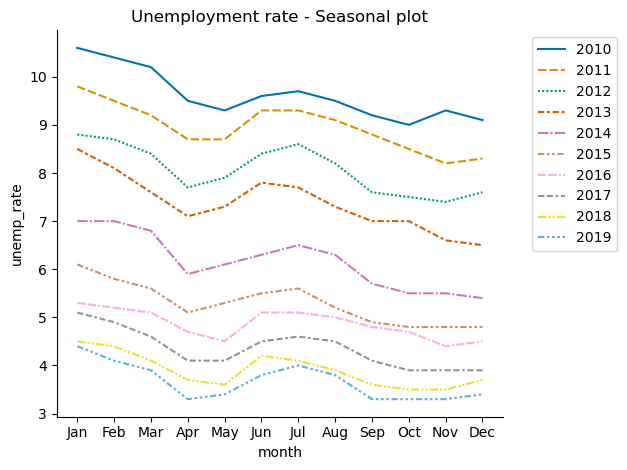

In [89]:
# quick look at the plot
temp_df = df.copy()

temp_df['year'] = temp_df.index.year
temp_df['month'] = temp_df.index.strftime('%b')

sns.lineplot(
    data=temp_df,
    x='month',
    y='unemp_rate',
    hue='year',
    style='year',
    legend='full',
    palette='colorblind'
)

plt.title('Unemployment rate - Seasonal plot')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

sns.despine()   # remove top and right spines from plot
plt.tight_layout()

### 3. Add rolling mean and standard deviation.

<Axes: title={'center': 'unemployment rate'}, xlabel='Date'>

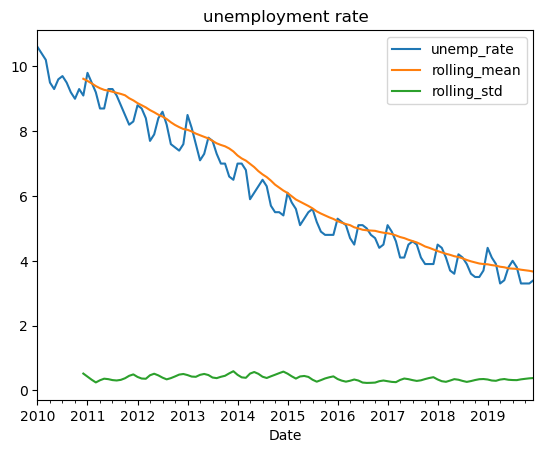

In [90]:
WINDOW_SIZE = 12
df['rolling_mean'] = df['unemp_rate'].rolling(WINDOW_SIZE).mean()
df['rolling_std'] = df['unemp_rate'].rolling(WINDOW_SIZE).std()
df.plot(title='unemployment rate')

### 4. Carry out the seasonal decompostiion using the additive model.

Text(0.5, 0.98, 'Addivie Decomposition')

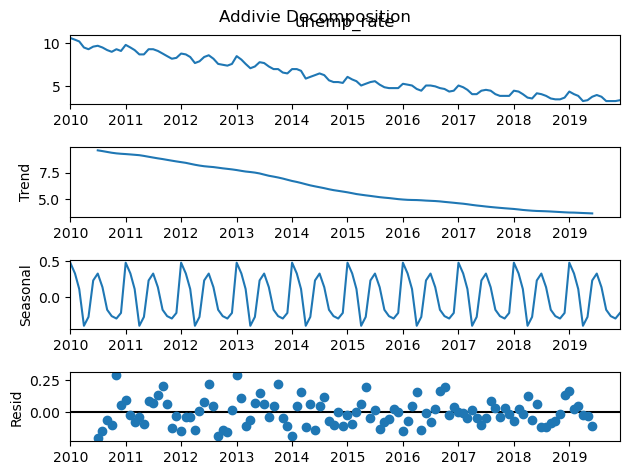

In [91]:
decomposition_results = seasonal_decompose(df['unemp_rate'], model='additive')

(
    decomposition_results
    .plot()
    .suptitle('Addivie Decomposition')
)

Text(0.5, 0.98, 'STL Decomposition')

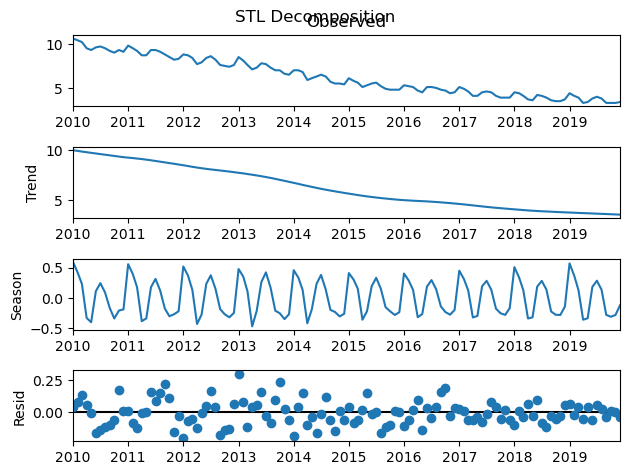

In [92]:
from statsmodels.tsa.seasonal import STL
stl_decomposition = STL(df[['unemp_rate']]).fit()
stl_decomposition.plot().suptitle('STL Decomposition')

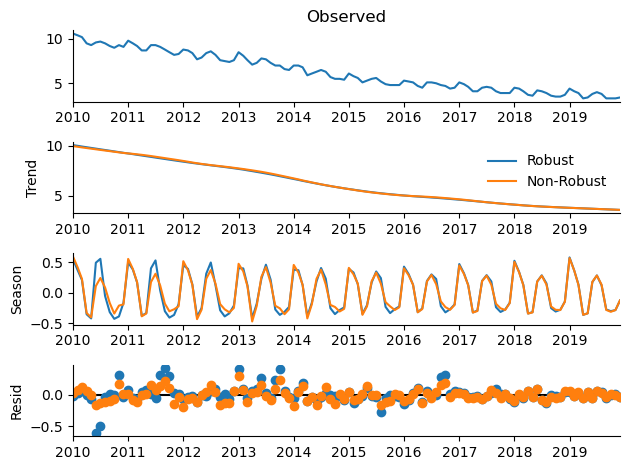

In [93]:
# Compare the decomposition with and without robust setting

def add_second_stl_to_plot(fig, fitted_stl, labels):
    """
    A helper function adding the 3 components from the second STL fit to the first STL plot.
    """

    axs = fig.get_axes()
    comps = ['trend', 'seasonal', 'resid']
    for ax, comp in zip(axs[1:], comps):
        series = getattr(fitted_stl, comp)
        if comp == 'resid':
            ax.plot(series, marker='o', linestyle='none')
        else:
            ax.plot(series)
            if comp == 'trend':
                ax.legend(labels, frameon=False)

stl_robust = STL(df[['unemp_rate']], robust=True).fit()
stl_non_robust = STL(df[['unemp_rate']], robust=False).fit()
fig = stl_robust.plot()
add_second_stl_to_plot(fig, stl_non_robust, ['Robust', 'Non-Robust'])

sns.despine()
plt.tight_layout()


# Testing for stationarity in time series

### 1. Import the libraries

In [94]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

### 2. Define a function for running the ADF test

In [95]:
def adf_test(x):
    indices = ['Test Statistic', 'p-value', '# of Lags Used', '# of Observations Used']

    adf_test = adfuller(x, autolag='AIC')
    results = pd.Series(adf_test[0:4], index=indices)

    for key, value in adf_test[4].items():
        results[f'Critical Value ({key})'] = value
    
    return results

In [96]:
adf_test(df['unemp_rate'])

Test Statistic             -2.053411
p-value                     0.263656
# of Lags Used             12.000000
# of Observations Used    107.000000
Critical Value (1%)        -3.492996
Critical Value (5%)        -2.888955
Critical Value (10%)       -2.581393
dtype: float64

### 3. Define a function for running the KPSS test

In [97]:
def kpss_test(x, h0_type='c'):
    indices = ['Test Statistic', 'p-value', '# of Lags']
    kpss_test = kpss(x, regression=h0_type)
    results = pd.Series(kpss_test[0:3], index=indices)

    for key, value in kpss_test[3].items():
        results[f'Critical Value ({key})'] = value
    
    return results

In [98]:
kpss_test(df['unemp_rate'])

/Users/woojin/miniforge3/envs/finance/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Test Statistic           1.799224
p-value                  0.010000
# of Lags                6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64

### 4. Generate the ACF/PACF plots

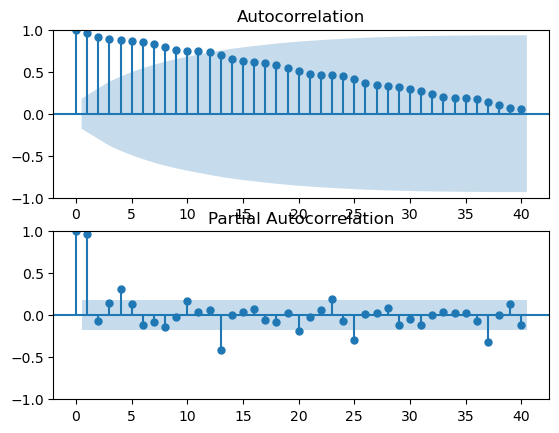

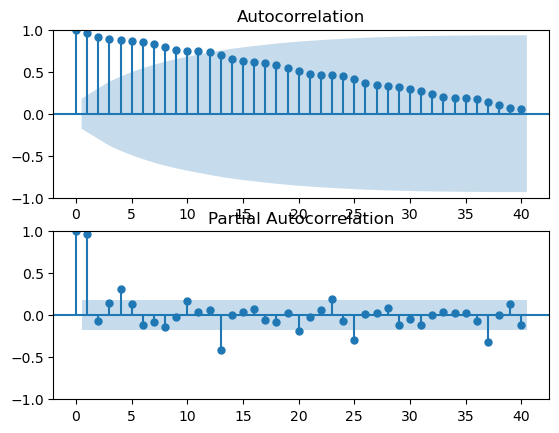

In [99]:
N_LAGS = 40
SIGNIFICANCE_LEVEL = 0.05
fig, ax = plt.subplots(2, 1)
plot_acf(df['unemp_rate'], ax=ax[0], lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL)
plot_pacf(df['unemp_rate'], ax=ax[1], lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL)

In [100]:
from arch.unitroot import ADF
adf = ADF(df['unemp_rate'])
print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.053
P-value                         0.264
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -3.49 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [101]:
from arch.unitroot import ZivotAndrews
za = ZivotAndrews(df['unemp_rate'])
print(za.summary().as_text())

        Zivot-Andrews Results        
Test Statistic                 -2.551
P-value                         0.982
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary.


# Correcting for stationary in time series

### 1. Import the libraries and authenticate and update the inflation data.

In [102]:
import pandas as pd
import numpy as np
import nasdaqdatalink
import cpi
from datetime import date
from chapter_6_utils import test_autocorrelation
nasdaqdatalink.ApiConfig.api_key = 'hbwVh8xyxkjEKo8D1P8c'

### 2. Download the prices of gold and resample to monthly values.

In [103]:
df = (
    nasdaqdatalink.get(dataset='WGC/GOLD_MONAVG_USD', start_date='2000-01-01', end_date='2010-12-31')
    .rename(columns={'Value': 'price'})
    .resample('M')
    .last()
)

ADF test statistics: 2.41 (p-val: 1.00)
KPSS test statistics: 1.84 (p-val: 0.01)


/Users/woojin/miniforge3/envs/finance/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


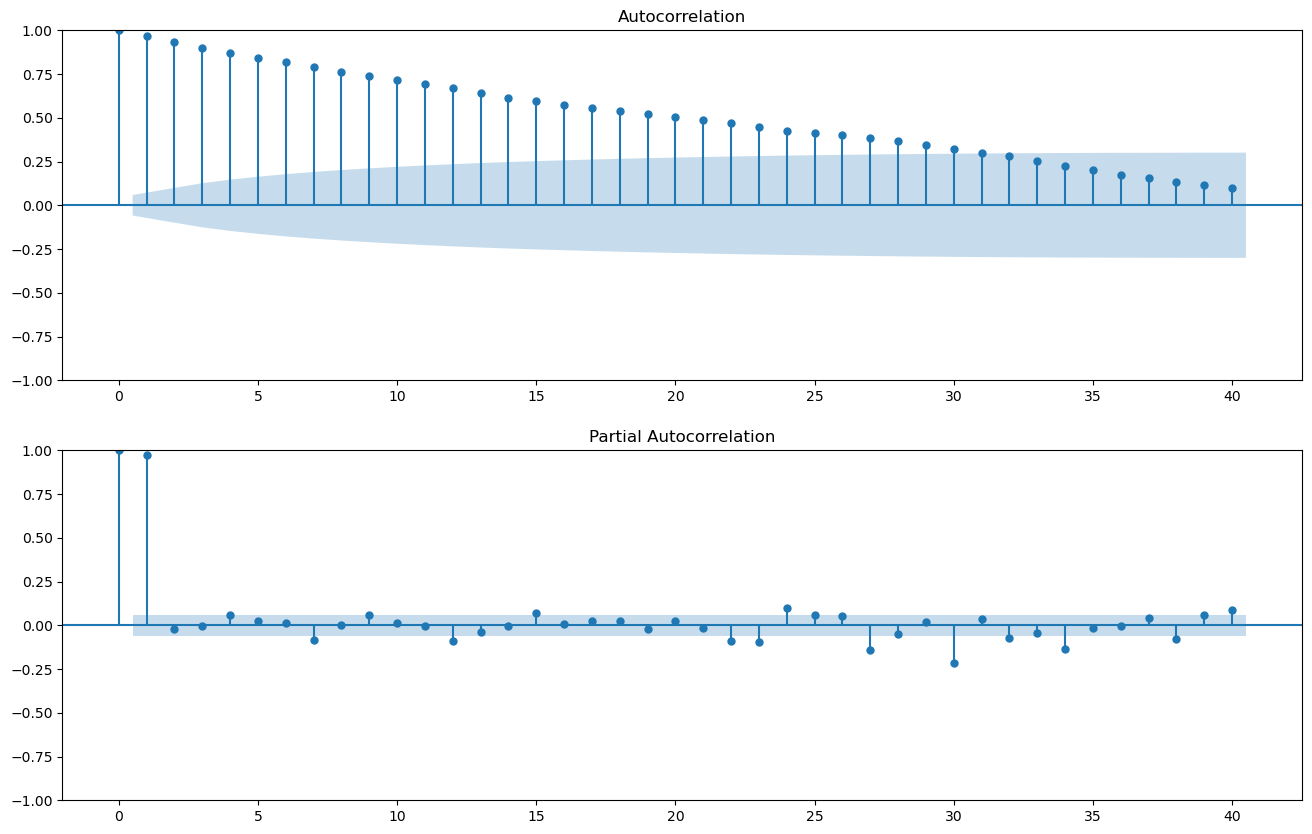

In [104]:
# check if the series is stationary - it is not
fig = test_autocorrelation(df['price'])

### 3. Deflate the gold prices (to the 2010-12-31 USD value) and plot the reulsts.

<Axes: title={'center': 'Gold Price (deflated)'}, xlabel='Date'>

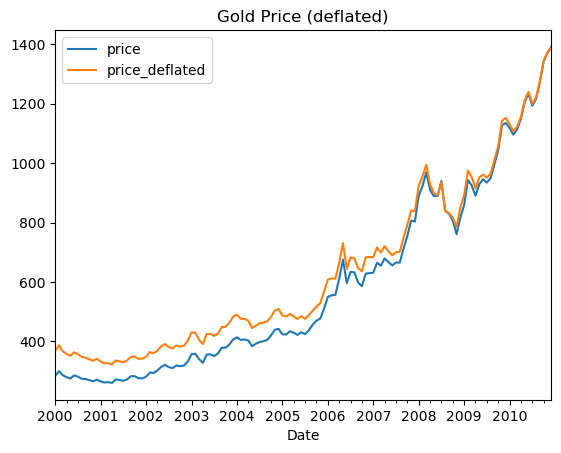

In [105]:
DEFL_DATE = date(2010, 12, 31)
df['df_index'] = pd.to_datetime(df.index)
df['price_deflated'] = df.apply(
    lambda x: cpi.inflate(x['price'], x['df_index'], DEFL_DATE),
    axis=1
)
(
    df.loc[:, ['price', 'price_deflated']]
    .plot(title='Gold Price (deflated)')
)

### 4. Apply the natural logarithm to the deflated series and plot it together with the rolling metrics.

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

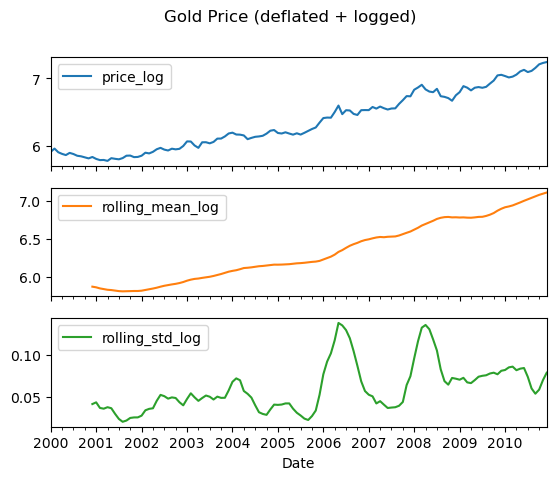

In [106]:
WINDOW = 12
selected_columns = ['price_log', 'rolling_mean_log', 'rolling_std_log']
df['price_log'] = np.log(df.price_deflated)
df['rolling_mean_log'] = df.price_log.rolling(WINDOW).mean()
df['rolling_std_log'] = df.price_log.rolling(WINDOW).std()
(
    df[selected_columns]
    .plot(title='Gold Price (deflated + logged)', subplots=True)
)

### 5. Use the test_autocorrelation to investigate if the series became stationary.

ADF test statistics: 1.04 (p-val: 0.99)
KPSS test statistics: 1.93 (p-val: 0.01)


/Users/woojin/miniforge3/envs/finance/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


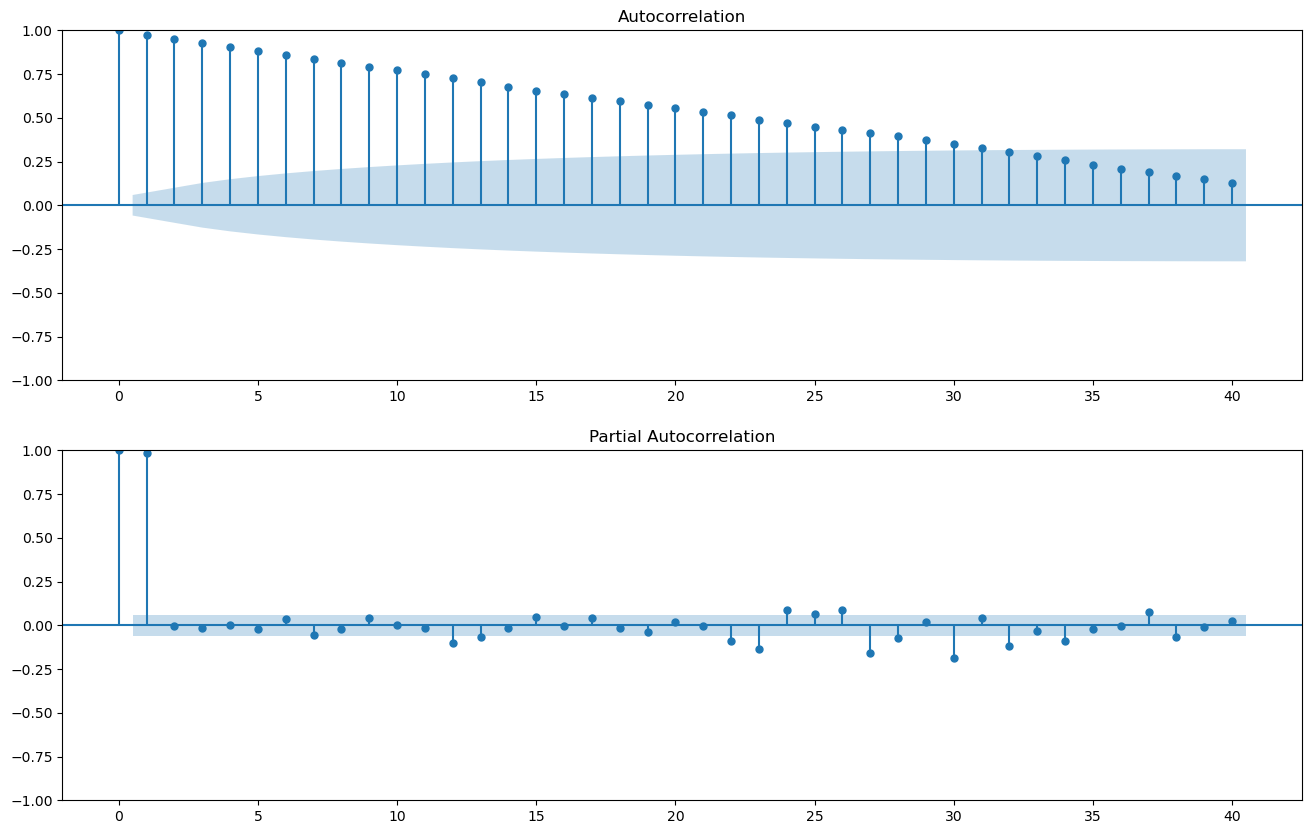

In [107]:
fig = test_autocorrelation(df['price_log'])

### 6. Apply differencing to the series and plot the results.

<Axes: title={'center': 'Gold Price (deflated + logged + diff)'}, xlabel='Date'>

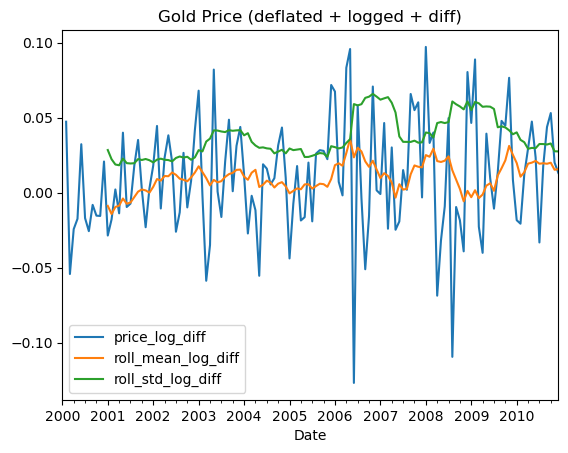

In [108]:
selected_columns = ['price_log_diff', 'roll_mean_log_diff', 'roll_std_log_diff']

df['price_log_diff'] = df.price_log.diff()
df['roll_mean_log_diff'] = df.price_log_diff.rolling(WINDOW).mean()
df['roll_std_log_diff'] = df.price_log_diff.rolling(WINDOW).std()

df[selected_columns].plot(title='Gold Price (deflated + logged + diff)')

### 7. Test if the series became stationary.

/Users/woojin/miniforge3/envs/finance/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


ADF test statistics: -10.87 (p-val: 0.00)
KPSS test statistics: 0.30 (p-val: 0.10)


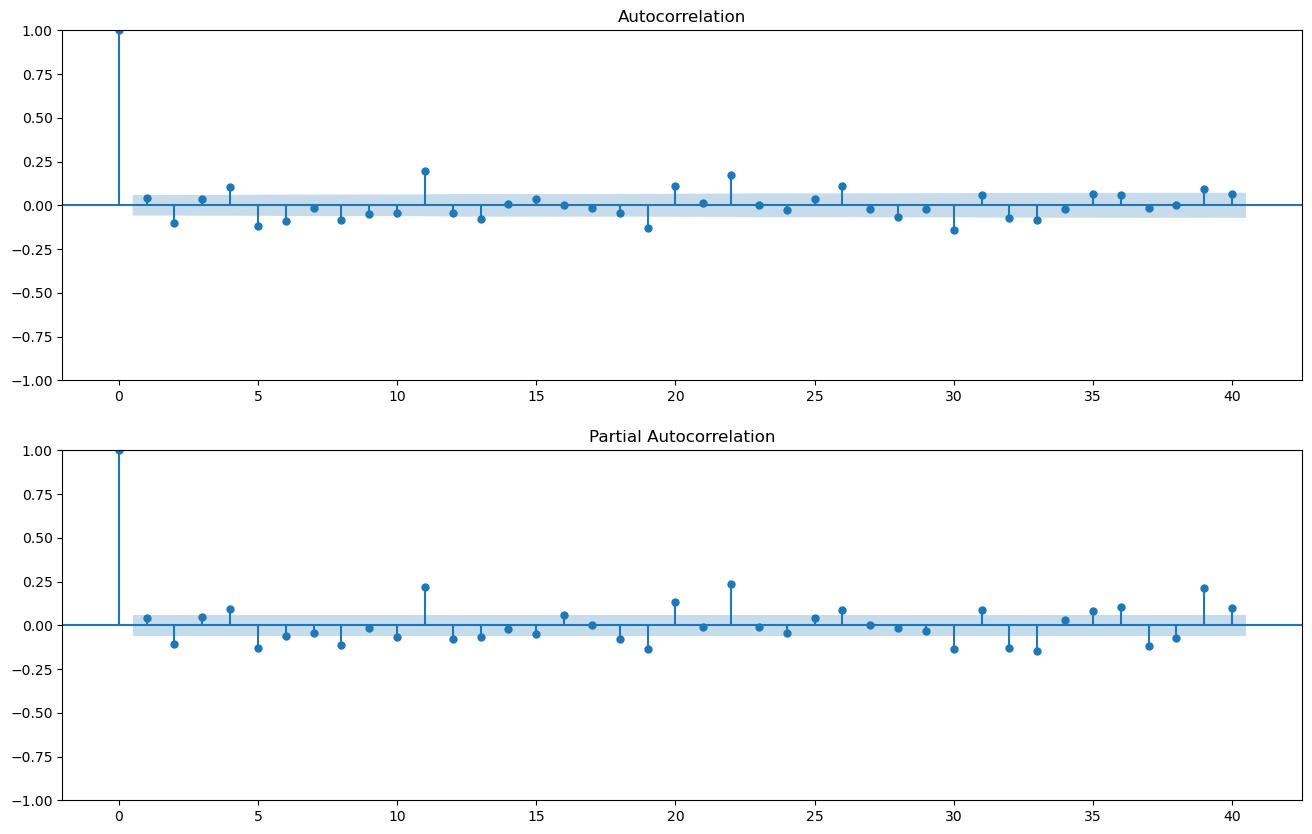

In [109]:
fig = test_autocorrelation(df['price_log_diff'].dropna())

In [110]:
# we can employ the following tests to investigate stationarity: ADF, KPSS, and Phillips-Perron.
from pmdarima.arima import ndiffs, nsdiffs

print(f"Suggested # of differeces (ADF): {ndiffs(df['price'], test='adf')}")
print(f"Suggested # of differeces (KPSS): {ndiffs(df['price'], test='kpss')}")
print(f"Suggested # of differeces (PP): {ndiffs(df['price'], test='pp')}")

Suggested # of differeces (ADF): 1
Suggested # of differeces (KPSS): 2
Suggested # of differeces (PP): 1


In [111]:
print(f'Suggested # of differences (OSCB): {nsdiffs(df["price"], m=12, test="ocsb")}')
print(f'Suggested # of differences (CH): {nsdiffs(df["price"], m=12, test="ch")}')

Suggested # of differences (OSCB): 0
Suggested # of differences (CH): 0


# Modeling time series iwth exponential smoothing methods

### 1. Getting ready

In [112]:
import pandas as pd
import nasdaqdatalink

nasdaqdatalink.ApiConfig.api_key = 'hbwVh8xyxkjEKo8D1P8c'

In [113]:
df = (
    nasdaqdatalink.get(dataset='FRED/UNRATENSA', start_date='2010-01-01', end_date='2019-12-31')
)
df.head()

,Value
Date,
2010-01-01,10.6
2010-02-01,10.4
2010-03-01,10.2
2010-04-01,9.5
2010-05-01,9.3


### 2. Import the libraries

In [114]:
import pandas as pd
from datetime import date
from statsmodels.tsa.holtwinters import (ExponentialSmoothing, SimpleExpSmoothing, Holt)

In [115]:
TEST_LENGTH = 12
df.index.freq = 'MS'
df_train = df.iloc[:-TEST_LENGTH]
df_test = df.iloc[-TEST_LENGTH:]

### 3. Fit two SES models and calculate the forecasts.

In [116]:
ses_1 = SimpleExpSmoothing(df_train).fit(smoothing_level=0.5)
ses_forecast_1 = ses_1.forecast(TEST_LENGTH)

ses_2 = SimpleExpSmoothing(df_train).fit()
ses_forecast_2 = ses_2.forecast(TEST_LENGTH)

ses_1.params_formatted

,name,param,optimized
smoothing_level,alpha,0.500000,False
initial_level,l.0,10.358112,True


In [117]:
ses_1.summary()

Dep. Variable:,Value,No. Observations:,108
Model:,SimpleExpSmoothing,SSE,15.032
Optimized:,True,AIC,-208.973
Trend:,None,BIC,-203.609
Seasonal:,None,AICC,-208.584
Seasonal Periods:,None,Date:,"Sat, 15 Jul 2023"
Box-Cox:,False,Time:,14:14:39
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5000000,alpha,False
initial_level,10.358112,l.0,True


### 4. Combine the forecasts with the fitted values and plot them.

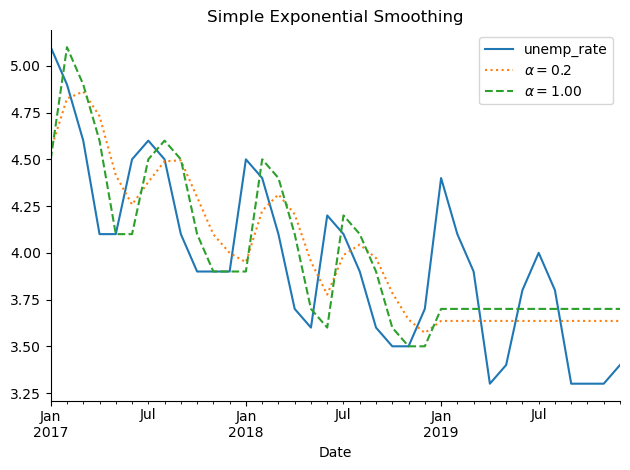

In [118]:
ses_df = df.copy()
ses_df["ses_1"] = ses_1.fittedvalues.append(ses_forecast_1)
ses_df["ses_2"] = ses_2.fittedvalues.append(ses_forecast_2)

opt_alpha = ses_2.model.params["smoothing_level"]

fig, ax = plt.subplots()
ses_df["2017":].plot(style=["-",":","--"], ax=ax,
                     title="Simple Exponential Smoothing")
labels = [
    "unemp_rate", 
    r"$\alpha=0.2$",
    r"$\alpha={0:.2f}$".format(opt_alpha), 
]
ax.legend(labels)

sns.despine()
plt.tight_layout()

### 5. Fit three variants of Holt’s linear trend models and calculate the forecasts.

In [119]:
# Holt's model with linear trend
hs_1 = Holt(df_train).fit()
hs_forecast_1 = hs_1.forecast(TEST_LENGTH)

# Holt's model with exponential trend
hs_2 = Holt(df_train, exponential=True).fit()
# equivalent to ExponentialSmoothing(df_train, trend="mul").fit()
hs_forecast_2 = hs_2.forecast(TEST_LENGTH)

# Holt's model with exponential trend and damping
hs_3 = Holt(df_train, exponential=False,
            damped_trend=True).fit()
hs_forecast_3 = hs_3.forecast(TEST_LENGTH)

In [120]:
hs_3.params_formatted

,name,param,optimized
smoothing_level,alpha,1.000000e+00,True
smoothing_trend,beta,1.396992e-15,True
initial_level,l.0,1.070994e+01,True
initial_trend,b.0,-1.102251e-01,True
damping_trend,phi,9.890185e-01,True


### 6. Plot the original series together with the model’s forecasts.

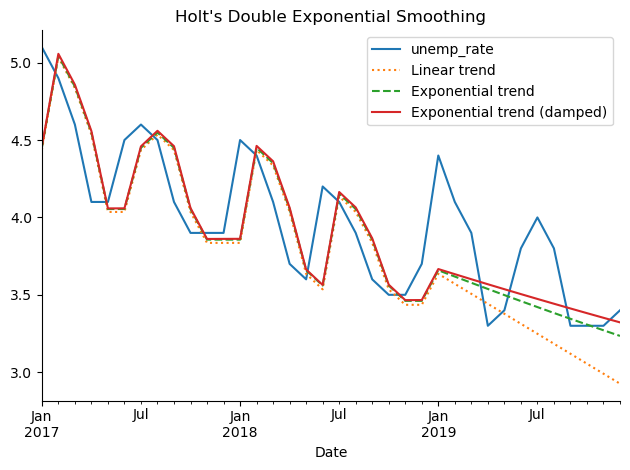

In [121]:
hs_df = df.copy()
hs_df["hs_1"] = hs_1.fittedvalues.append(hs_forecast_1)
hs_df["hs_2"] = hs_2.fittedvalues.append(hs_forecast_2)
hs_df["hs_3"] = hs_3.fittedvalues.append(hs_forecast_3)

fig, ax = plt.subplots()
hs_df["2017":].plot(style=["-",":","--"], ax=ax,
                    title="Holt's Double Exponential Smoothing")

labels = [
    "unemp_rate",
    "Linear trend",
    "Exponential trend",
    "Exponential trend (damped)"
]

ax.legend(labels)

sns.despine()
plt.tight_layout()

### 7. Fit two variants of Hold-Winters’ Triple Exponential Smoothing models and calculate the forecasts.

In [122]:
SEASONAL_PERIODS = 12

# Holt-Winters' model with exponential trend
hw_1 = ExponentialSmoothing(df_train, 
                            trend="mul",
                            seasonal="add",
                            seasonal_periods=SEASONAL_PERIODS).fit()
hw_forecast_1 = hw_1.forecast(TEST_LENGTH)

# Holt-Winters' model with exponential trend and damping
hw_2 = ExponentialSmoothing(df_train,
                            trend="mul",
                            seasonal="add",
                            seasonal_periods=SEASONAL_PERIODS,
                            damped_trend=True).fit()
hw_forecast_2 = hw_2.forecast(TEST_LENGTH)

In [123]:
hw_2.params_formatted

,name,param,optimized
smoothing_level,alpha,0.632942,True
smoothing_trend,beta,0.000000,True
smoothing_seasonal,gamma,0.000000,True
initial_level,l.0,8.210423,True
initial_trend,b.0,1.009639,True
damping_trend,phi,0.972787,True
initial_seasons.0,s.0,2.529609,True
initial_seasons.1,s.1,2.400610,True
initial_seasons.2,s.2,2.193658,True
initial_seasons.3,s.3,1.686383,True


### 8. Plot the original series together with the model's results.

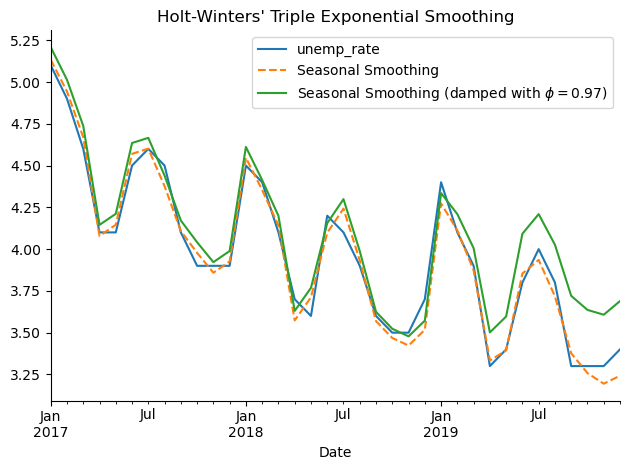

In [124]:
hw_df = df.copy()
hw_df["hw_1"] = hw_1.fittedvalues.append(hw_forecast_1)
hw_df["hw_2"] = hw_2.fittedvalues.append(hw_forecast_2)

fig, ax = plt.subplots()
hw_df["2017":].plot(style=["-", "--"], ax=ax,
                    title="Holt-Winters' Triple Exponential Smoothing")

phi = hw_2.model.params["damping_trend"]

labels = [
    "unemp_rate",
    "Seasonal Smoothing",
    f"Seasonal Smoothing (damped with $\phi={phi:.2f}$)"
]

ax.legend(labels)

sns.despine()
plt.tight_layout()

## There's more

### 1. Import the libraries

In [125]:
from sktime.forecasting.ets import AutoETS
from sklearn.metrics import mean_absolute_percentage_error

### 2. Fit the `AutoETS` model

In [126]:
auto_ets = AutoETS(auto=True, n_jobs=-1, sp=12)
auto_ets.fit(df_train.to_period())
auto_ets_fcst = auto_ets.predict(fh=list(range(1, 13)))

In [127]:
auto_ets.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  108
Model:                      ETS(MAdA)   Log Likelihood                  67.065
Date:                Sat, 15 Jul 2023   AIC                            -96.130
Time:                        14:14:41   BIC                            -45.169
Sample:                    01-31-2010   HQIC                           -75.467
                         - 12-31-2018   Scale                            0.000
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.6208      0.094      6.609      0.000       0.437       0.805
smoothing_trend         0.0204        nan        nan        nan         nan         nan
smoothing_seasonal   3.792e-05        nan        nan        nan         nan         nan
damping_trend           0.9800        nan        nan        nan         nan         nan
initial_level          10.7177    880.373      0.012      0.990   -1714.782    1736.218
initial_trend          -0.1119      0.043     -2.577      0.010      -0.197      -0.027
initial_seasonal.0     -0.6403    880.373     -0.001      0.999   -1726.140    1724.860
initial_seasonal.1     -0.7357    880.373     -0.001      0.999   -1726.236    1724.764
initial_seasonal.2     -0.7085    880.373     -0.001      0.999   -1726.208    1724.791
initial_seasonal.3     -0.6170    880.373     -0.001      0.999   -1726.117    1724.883
initial_seasonal.4     -0.3149    880.373     -0.000      1.000   -1725.815    1725.185
initial_seasonal.5     -0.1465    880.373     -0.000      1.000   -1725.646    1725.353
initial_seasonal.6     -0.2301    880.373     -0.000      1.000   -1725.730    1725.270
initial_seasonal.7     -0.7316    880.373     -0.001      0.999   -1726.231    1724.768
initial_seasonal.8     -0.7838    880.373     -0.001      0.999   -1726.284    1724.716
initial_seasonal.9     -0.3214    880.373     -0.000      1.000   -1725.821    1725.179
initial_seasonal.10    -0.1175    880.373     -0.000      1.000   -1725.617    1725.382
initial_seasonal.11          0    880.373          0      1.000   -1725.500    1725.500
===================================================================================
Ljung-Box (Q):                       28.47   Jarque-Bera (JB):                 0.18
Prob(Q):                              0.13   Prob(JB):                         0.92
Heteroskedasticity (H):               1.69   Skew:                            -0.04
Prob(H) (two-sided):                  0.12   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

### 3. Add the model’s forecast to the plot of the Holt-Winters’ forecast.

In [128]:
auto_ets_fcst

,Value
2019-01,4.260262
2019-02,4.121496
2019-03,3.896830
2019-04,3.413996
2019-05,3.446215
2019-06,3.928092
2019-07,3.992521
2019-08,3.805316
2019-09,3.484785
2019-10,3.375151


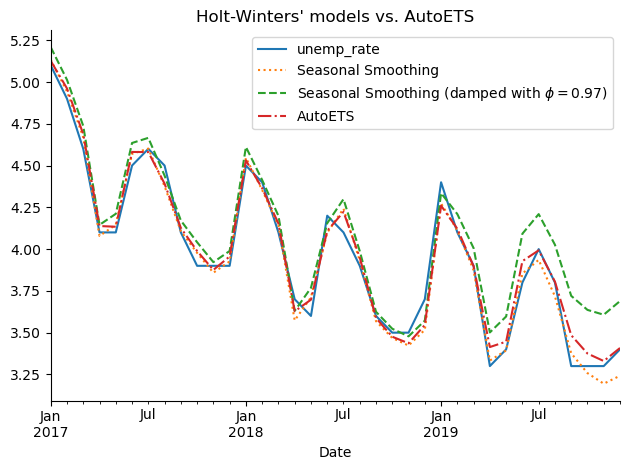

In [129]:
auto_ets_df = hw_df.to_period().copy()
auto_ets_df["auto_ets"] = (
    auto_ets
    ._fitted_forecaster
    .fittedvalues
    .append(auto_ets_fcst["Value"])
)

fig, ax = plt.subplots()
auto_ets_df["2017":].plot(
    style=["-",":","--","-."], ax=ax,
    title="Holt-Winters' models vs. AutoETS"
)
labels = [
    "unemp_rate", 
    "Seasonal Smoothing",
    f"Seasonal Smoothing (damped with $\phi={phi:.2f}$)",
    "AutoETS",
]
ax.legend(labels)

sns.despine()
plt.tight_layout()

### 4. Calculate the MAPEs of the Holt-Winters' forecast and of AutoETS

In [130]:
fcst_dict = {
    "Seasonal Smoothing": hw_forecast_1,
    "Seasonal Smoothing (damped)": hw_forecast_2,
    "AutoETS": auto_ets_fcst
}

print("MAPEs ----")
for key, value in fcst_dict.items():
    mape = mean_absolute_percentage_error(df_test, value)
    print(f"{key}: {100 * mape:.2f}%" )

MAPEs ----
Seasonal Smoothing: 1.81%
Seasonal Smoothing (damped): 6.53%
AutoETS: 1.78%


# Modeling time series with ARIMA class models

## Getting ready

### 1. Import the libraries and authenticate

In [131]:
import pandas as pd
import nasdaqdatalink

nasdaqdatalink.ApiConfig.api_key = 'hbwVh8xyxkjEKo8D1P8c'

### 2. Download the monthly US unemploymwent rate from years 2010-2019

In [132]:
df = (
    nasdaqdatalink.get(dataset='FRED/UNRATENSA',
                       start_date='2010-01-01',
                       end_date='2019-12-31')
    .rename(columns={"Value": "unemp_rate"})
)

# to hide the warnings of 'statsmodels'
df.index.freq = 'MS'

df.head()

,unemp_rate
Date,
2010-01-01,10.6
2010-02-01,10.4
2010-03-01,10.2
2010-04-01,9.5
2010-05-01,9.3


## How to do it

### 1. Import the libraries.

In [133]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from chapter_6_utils import test_autocorrelation
from sklearn.metrics import mean_absolute_percentage_error
import seaborn as sns
import matplotlib.pyplot as plt

### 2. Create the train/test split

In [134]:
TEST_LENGTH = 12
df_train = df.iloc[:-TEST_LENGTH]
df_test = df.iloc[-TEST_LENGTH:]

### 3. Apply the log transformation

/var/folders/dt/q9f0jq252ld5kmwg8rqf4pgw0000gn/T/ipykernel_49274/2960053991.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['unemp_rate_log'] = np.log(df_train['unemp_rate'])
/var/folders/dt/q9f0jq252ld5kmwg8rqf4pgw0000gn/T/ipykernel_49274/2960053991.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['first_diff'] = df_train['unemp_rate_log'].diff()


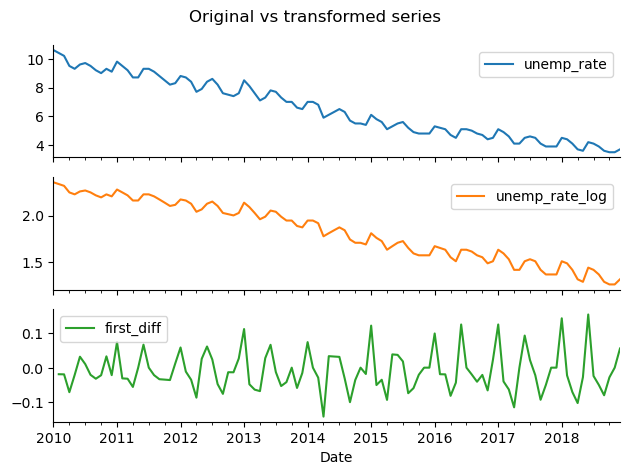

In [135]:
df_train['unemp_rate_log'] = np.log(df_train['unemp_rate'])
df_train['first_diff'] = df_train['unemp_rate_log'].diff()

df_train.plot(subplots=True, 
              title="Original vs transformed series")

sns.despine()
plt.tight_layout()

### 4. Test the stationarity of the differenced series.

ADF test statistics: -2.97 (p-val: 0.04)
KPSS test statistics: 0.04 (p-val: 0.10)


/Users/woojin/miniforge3/envs/finance/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


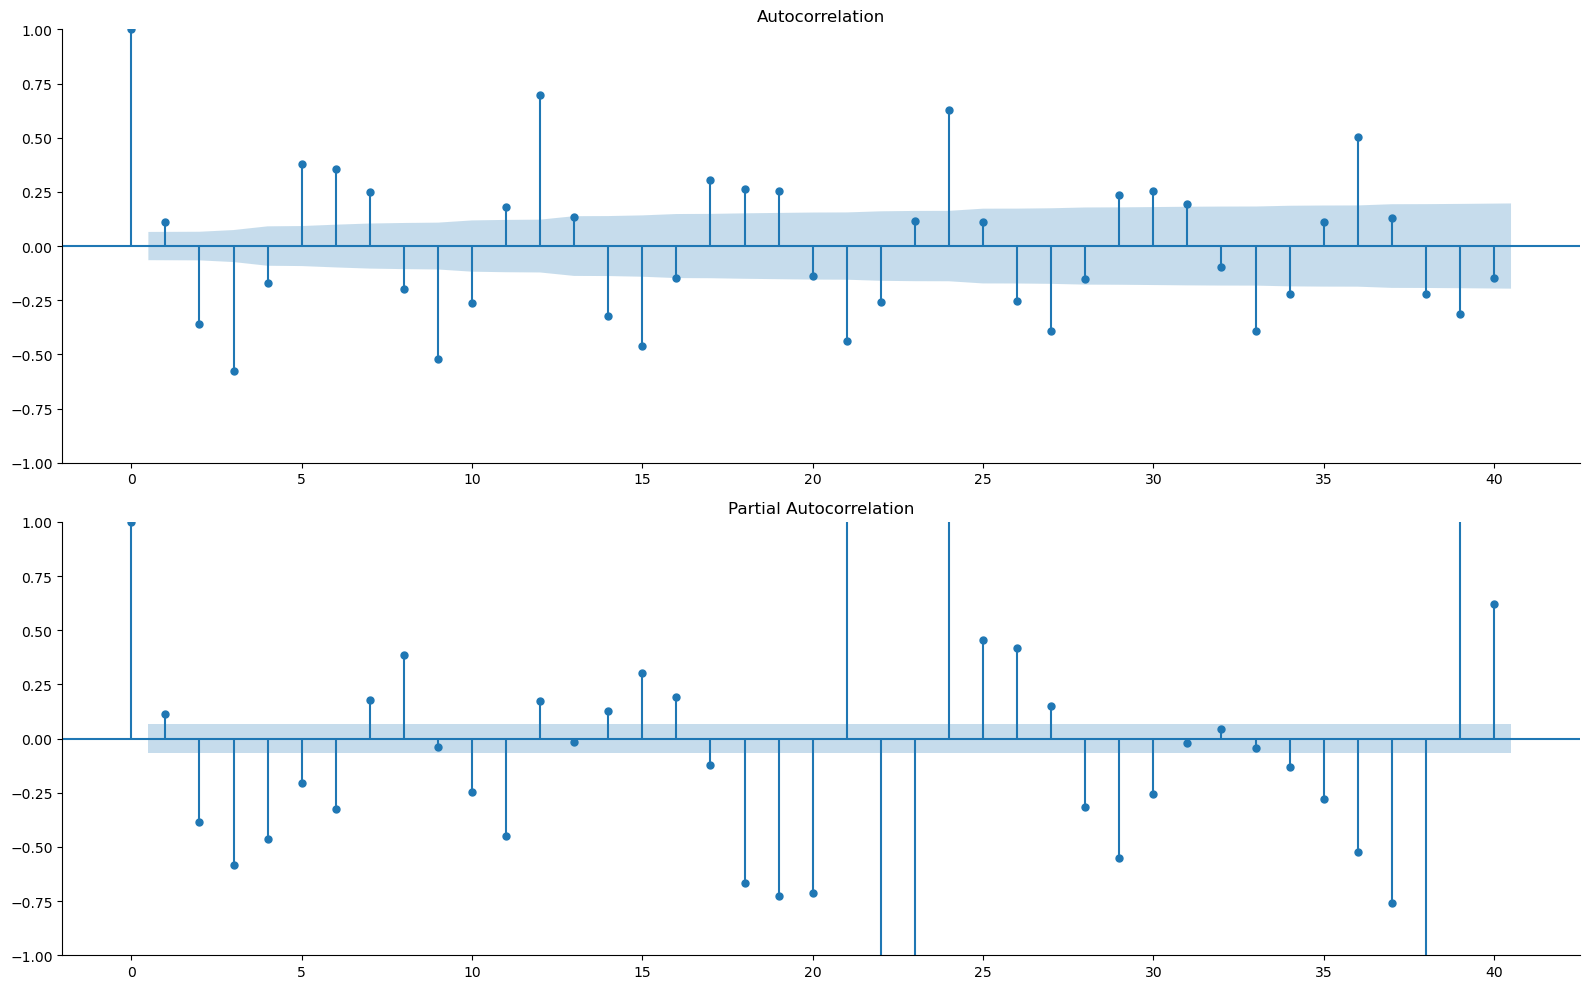

In [136]:
fig = test_autocorrelation(df_train['first_diff'].dropna())

sns.despine()
plt.tight_layout()

### 5. Fit the different ARIMA models and print their summaries.

In [137]:
arima_111 = ARIMA(
    df_train['unemp_rate_log'], order=(1, 1, 1)
).fit()
arima_111.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         unemp_rate_log   No. Observations:                  108
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 157.020
Date:                Sat, 15 Jul 2023   AIC                           -308.040
Time:                        14:14:43   BIC                           -300.021
Sample:                    01-01-2010   HQIC                          -304.789
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5541      0.401      1.381      0.167      -0.232       1.340
ma.L1         -0.7314      0.306     -2.391      0.017      -1.331      -0.132
sigma2         0.0031      0.000      6.822      0.000       0.002       0.004
===================================================================================
Ljung-Box (L1) (Q):                   2.55   Jarque-Bera (JB):                 9.59
Prob(Q):                              0.11   Prob(JB):                         0.01
Heteroskedasticity (H):               2.33   Skew:                             0.64
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [138]:
arima_212 = ARIMA(
    df_train['unemp_rate_log'], order=(2, 1, 2)
).fit()
arima_212.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         unemp_rate_log   No. Observations:                  108
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 196.744
Date:                Sat, 15 Jul 2023   AIC                           -383.488
Time:                        14:14:43   BIC                           -370.124
Sample:                    01-01-2010   HQIC                          -378.070
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9952      0.014     69.720      0.000       0.967       1.023
ar.L2         -0.9894      0.014    -70.200      0.000      -1.017      -0.962
ma.L1         -1.1435     36.823     -0.031      0.975     -73.315      71.028
ma.L2          1.0000     64.406      0.016      0.988    -125.233     127.233
sigma2         0.0014      0.088      0.016      0.988      -0.171       0.174
===================================================================================
Ljung-Box (L1) (Q):                  11.32   Jarque-Bera (JB):                 3.24
Prob(Q):                              0.00   Prob(JB):                         0.20
Heteroskedasticity (H):               1.99   Skew:                             0.40
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 6. Combine the fitted values with the predictions.

In [139]:
df['pred_111_log'] = (
    arima_111
    .fittedvalues
    .append(arima_111.forecast(TEST_LENGTH))
)
df['pred_111'] = np.exp(df['pred_111_log'])

df['pred_212_log'] = (
    arima_212
    .fittedvalues
    .append(arima_212.forecast(TEST_LENGTH))
)
df['pred_212'] = np.exp(df['pred_212_log'])
df

,unemp_rate,pred_111_log,pred_111,pred_212_log,pred_212
Date,,,,,
2010-01-01,10.6,0.000000,1.000000,0.000000,1.000000
2010-02-01,10.4,2.360854,10.600000,2.360854,10.600000
2010-03-01,10.2,2.344579,10.428883,2.337656,10.356933
2010-04-01,9.5,2.327492,10.252193,2.324149,10.217983
2010-05-01,9.3,2.266965,9.650071,2.256315,9.547840
...,...,...,...,...,...
2019-08-01,3.8,1.308392,3.700221,1.340874,3.822385
2019-09-01,3.3,1.308393,3.700221,1.272437,3.569539
2019-10-01,3.3,1.308393,3.700222,1.222046,3.394125


In [140]:
#  The number of initial periods during which the loglikelihood is not recorded. Default is 0.
arima_111.loglikelihood_burn

1

In [141]:
arima_111.nobs_diffuse

0

### 7. Plot the forecast and calculate MAPEs.

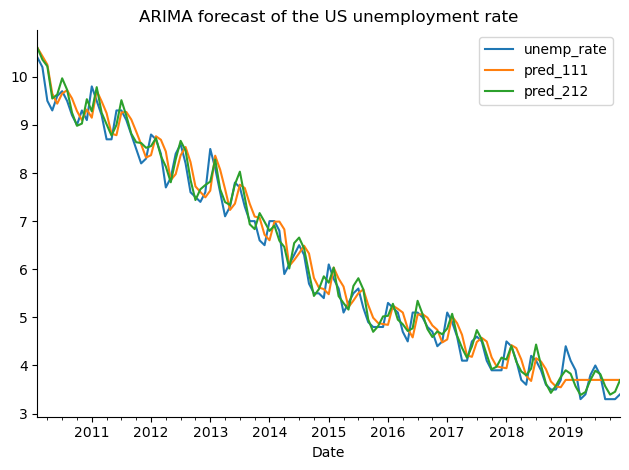

In [142]:
(
    df[['unemp_rate', 'pred_111', 'pred_212']]
    .iloc[1:]
    .plot(title='ARIMA forecast of the US unemployment rate')
)

sns.despine()
plt.tight_layout()

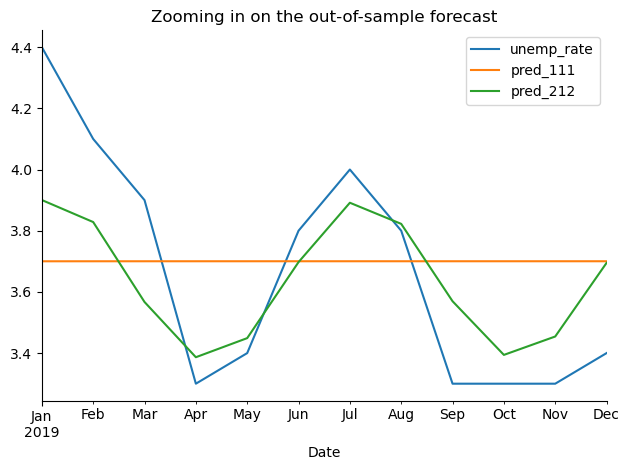

In [143]:
(
    df[['unemp_rate', 'pred_111', 'pred_212']]
    .iloc[-TEST_LENGTH:]
    .plot(title='Zooming in on the out-of-sample forecast')
)

sns.despine()
plt.tight_layout()

In [144]:
mape_111 = mean_absolute_percentage_error(
    df['unemp_rate'].iloc[-TEST_LENGTH:],
    df['pred_111'].iloc[-TEST_LENGTH:]
)

mape_212 = mean_absolute_percentage_error(
    df['unemp_rate'].iloc[-TEST_LENGTH:],
    df['pred_212'].iloc[-TEST_LENGTH:]
)

print(f"MAPE of ARIMA(1, 1, 1): {100 * mape_111:.2f}%")
print(f'MAPE of ARIMA(2, 1, 2): {100 * mape_212:.2f}%')

MAPE of ARIMA(1, 1, 1): 9.14%
MAPE of ARIMA(2, 1, 2): 5.08%


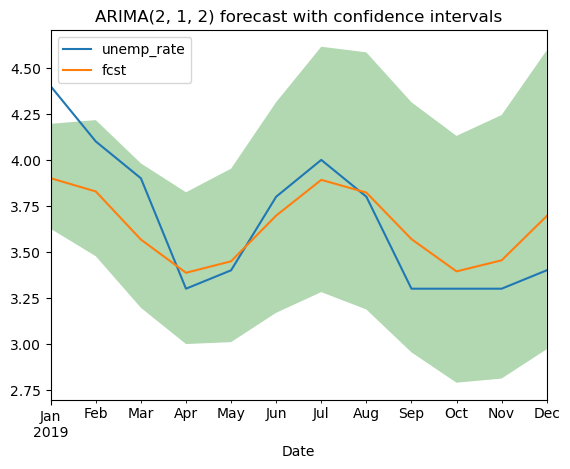

In [145]:
pred_df = arima_212.get_forecast(TEST_LENGTH).summary_frame()
pred_df.columns = ['fcst', 'fcst_se', 'ci_lower', 'ci_upper']
plot_df = df_test[['unemp_rate']].join(np.exp(pred_df))

fig, ax = plt.subplots()
(
    plot_df[['unemp_rate', 'fcst']]
    .plot(ax=ax, title='ARIMA(2, 1, 2) forecast with confidence intervals')
)

ax.fill_between(plot_df.index,
                plot_df['ci_lower'],
                plot_df['ci_upper'],
                alpha=0.3,
                facecolor='g')
ax.legend(loc='upper left')

## There's more

### 1. Plot diagnostic plots for the residuals of the fitted ARIMA(2, 1, 2) model.

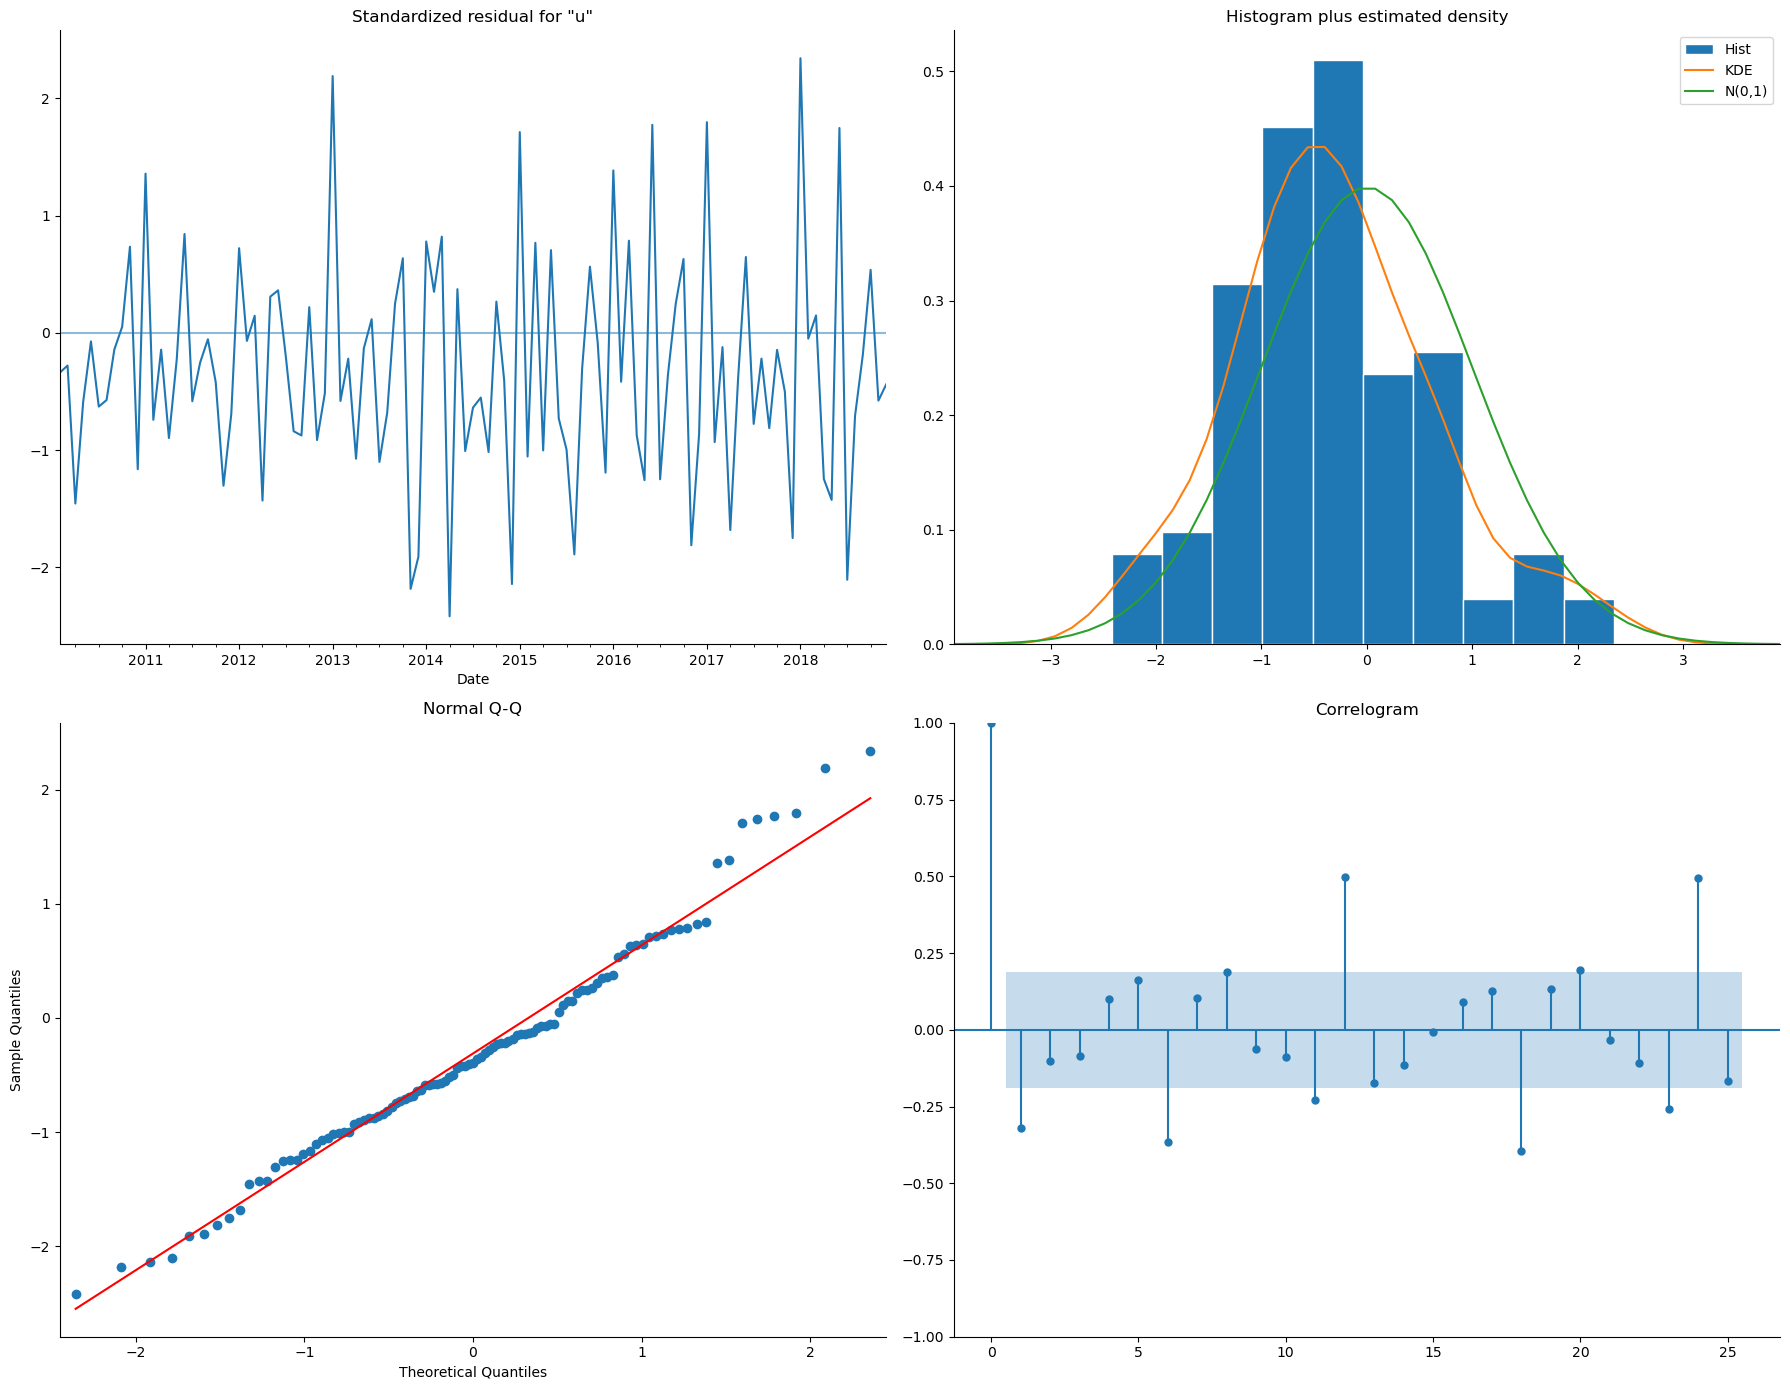

In [146]:
arima_212.plot_diagnostics(figsize=(18, 14), lags=25)

sns.despine()
plt.tight_layout()

### 2. Apply the LJung-Box's test for no autocorrelation in the residuals and plot the results.

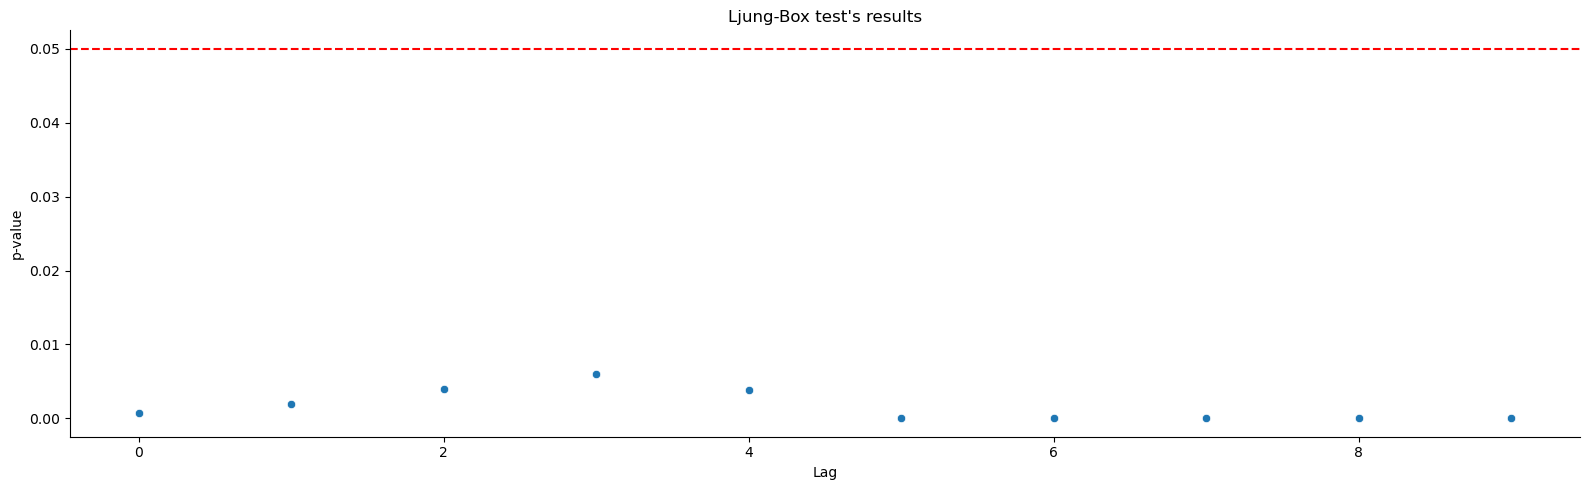

In [147]:
ljung_box_results = arima_212.test_serial_correlation(method='ljungbox')
ljung_box_pvals = ljung_box_results[0][1]

fig, ax = plt.subplots(1, figsize=[16, 5])
sns.scatterplot(x=range(len(ljung_box_pvals)), y=ljung_box_pvals, ax=ax)
ax.axhline(0.05, color='r', linestyle='--')
ax.set(title="Ljung-Box test's results",
       xlabel='Lag',
       ylabel='p-value')
sns.despine()
plt.tight_layout()

In [148]:
# alternative wat to get the same test results
from statsmodels.stats.diagnostic import acorr_ljungbox
ljung_box_results_df = acorr_ljungbox(arima_212.resid[1:])
ljung_box_results_df

,lb_stat,lb_pvalue
1,10.682865,0.001081
2,11.727458,0.002841
3,12.512365,0.005819
4,13.651062,0.008496
5,16.477101,0.005606
6,31.830038,0.000018
7,32.952485,0.000027
8,37.007941,0.000011
9,37.572825,0.000021
10,38.471715,0.000031


The first residual of the fitted ARIMA/ARMA model is equal to the first observation of the time series. For more inforamtion, please see the following:

- https://stats.stackexchange.com/questions/202903/start-up-values-for-the-kalman-filter/221723#221723

In [149]:
df_train

,unemp_rate,unemp_rate_log,first_diff
Date,,,
2010-01-01,10.6,2.360854,NaN
2010-02-01,10.4,2.341806,-0.019048
2010-03-01,10.2,2.322388,-0.019418
2010-04-01,9.5,2.251292,-0.071096
2010-05-01,9.3,2.230014,-0.021277
...,...,...,...
2018-08-01,3.9,1.360977,-0.050010
2018-09-01,3.6,1.280934,-0.080043
2018-10-01,3.5,1.252763,-0.028171


In [150]:
arima_212.resid

Date
2010-01-01    2.360854
2010-02-01   -0.019048
2010-03-01   -0.015268
2010-04-01   -0.072857
2010-05-01   -0.026301
                ...   
2018-08-01   -0.026483
2018-09-01   -0.007010
2018-10-01    0.020048
2018-11-01   -0.021570
2018-12-01   -0.016412
Freq: MS, Length: 108, dtype: float64

In [151]:
arima_212.test_normality(method='jarquebera')

array([[3.24111957, 0.19778795, 0.40360714, 3.27456367]])

In [152]:
arima_212.test_heteroskedasticity(method='breakvar')

array([[1.99122559, 0.04211955]])

# Finding the best-fitting ARIMA model with auto-ARIMA

## Getting ready

### 1. Import the libraries and authenticate.

In [153]:
import pandas as pd
import nasdaqdatalink

nasdaqdatalink.ApiConfig.api_key = 'hbwVh8xyxkjEKo8D1P8c'

### 2. Download the monthly US unemployment rate from years 2010-2019.

In [154]:
df = (
    nasdaqdatalink.get(dataset='FRED/UNRATENSA',
                          start_date='2010-01-01',
                            end_date='2019-12-31')
    .rename(columns={"Value": "unemp_rate"})
)

# to hide the warnings of 'statsmodels'
df.index.freq = 'MS'

df.head()

,unemp_rate
Date,
2010-01-01,10.6
2010-02-01,10.4
2010-03-01,10.2
2010-04-01,9.5
2010-05-01,9.3


## How to do it

### 1. Import the libraries

In [155]:
import pandas as pd
import pmdarima as pm
from sklearn.metrics import mean_absolute_percentage_error

### 2. Create the train/test split.

In [156]:
TEST_LENGTH = 12
df_train = df.iloc[:-TEST_LENGTH]
df_test = df.iloc[-TEST_LENGTH:]

### 3. Find the best hyperparameters of the ARIMA model using the auto-ARIMA procedure.

In [157]:
auto_arima = pm.auto_arima(df_train,
                           test='adf',
                           seasonal=False,
                           with_intercept=False,
                           stepwise=True,
                           suppress_warnings=True,
                           trace=True)

auto_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=7.411, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=77.864, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=77.461, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=75.688, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=68.551, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=54.321, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=7.458, Time=0.14 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=78.507, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=60.069, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=41.703, Time=0.03 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=10.333, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 0.825 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  108
Model:               SARIMAX(2, 1, 2)   Log Likelihood                   1.294
Date:                Sat, 15 Jul 2023   AIC                              7.411
Time:                        14:14:45   BIC                             20.775
Sample:                    01-01-2010   HQIC                            12.829
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9882      0.028     34.788      0.000       0.933       1.044
ar.L2         -0.9630      0.023    -41.667      0.000      -1.008      -0.918
ma.L1         -1.1926      0.057    -21.093      0.000      -1.303      -1.082
ma.L2          0.9241      0.063     14.580      0.000       0.800       1.048
sigma2         0.0550      0.009      6.066      0.000       0.037       0.073
===================================================================================
Ljung-Box (L1) (Q):                   5.22   Jarque-Bera (JB):                 4.47
Prob(Q):                              0.02   Prob(JB):                         0.11
Heteroskedasticity (H):               0.52   Skew:                             0.44
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

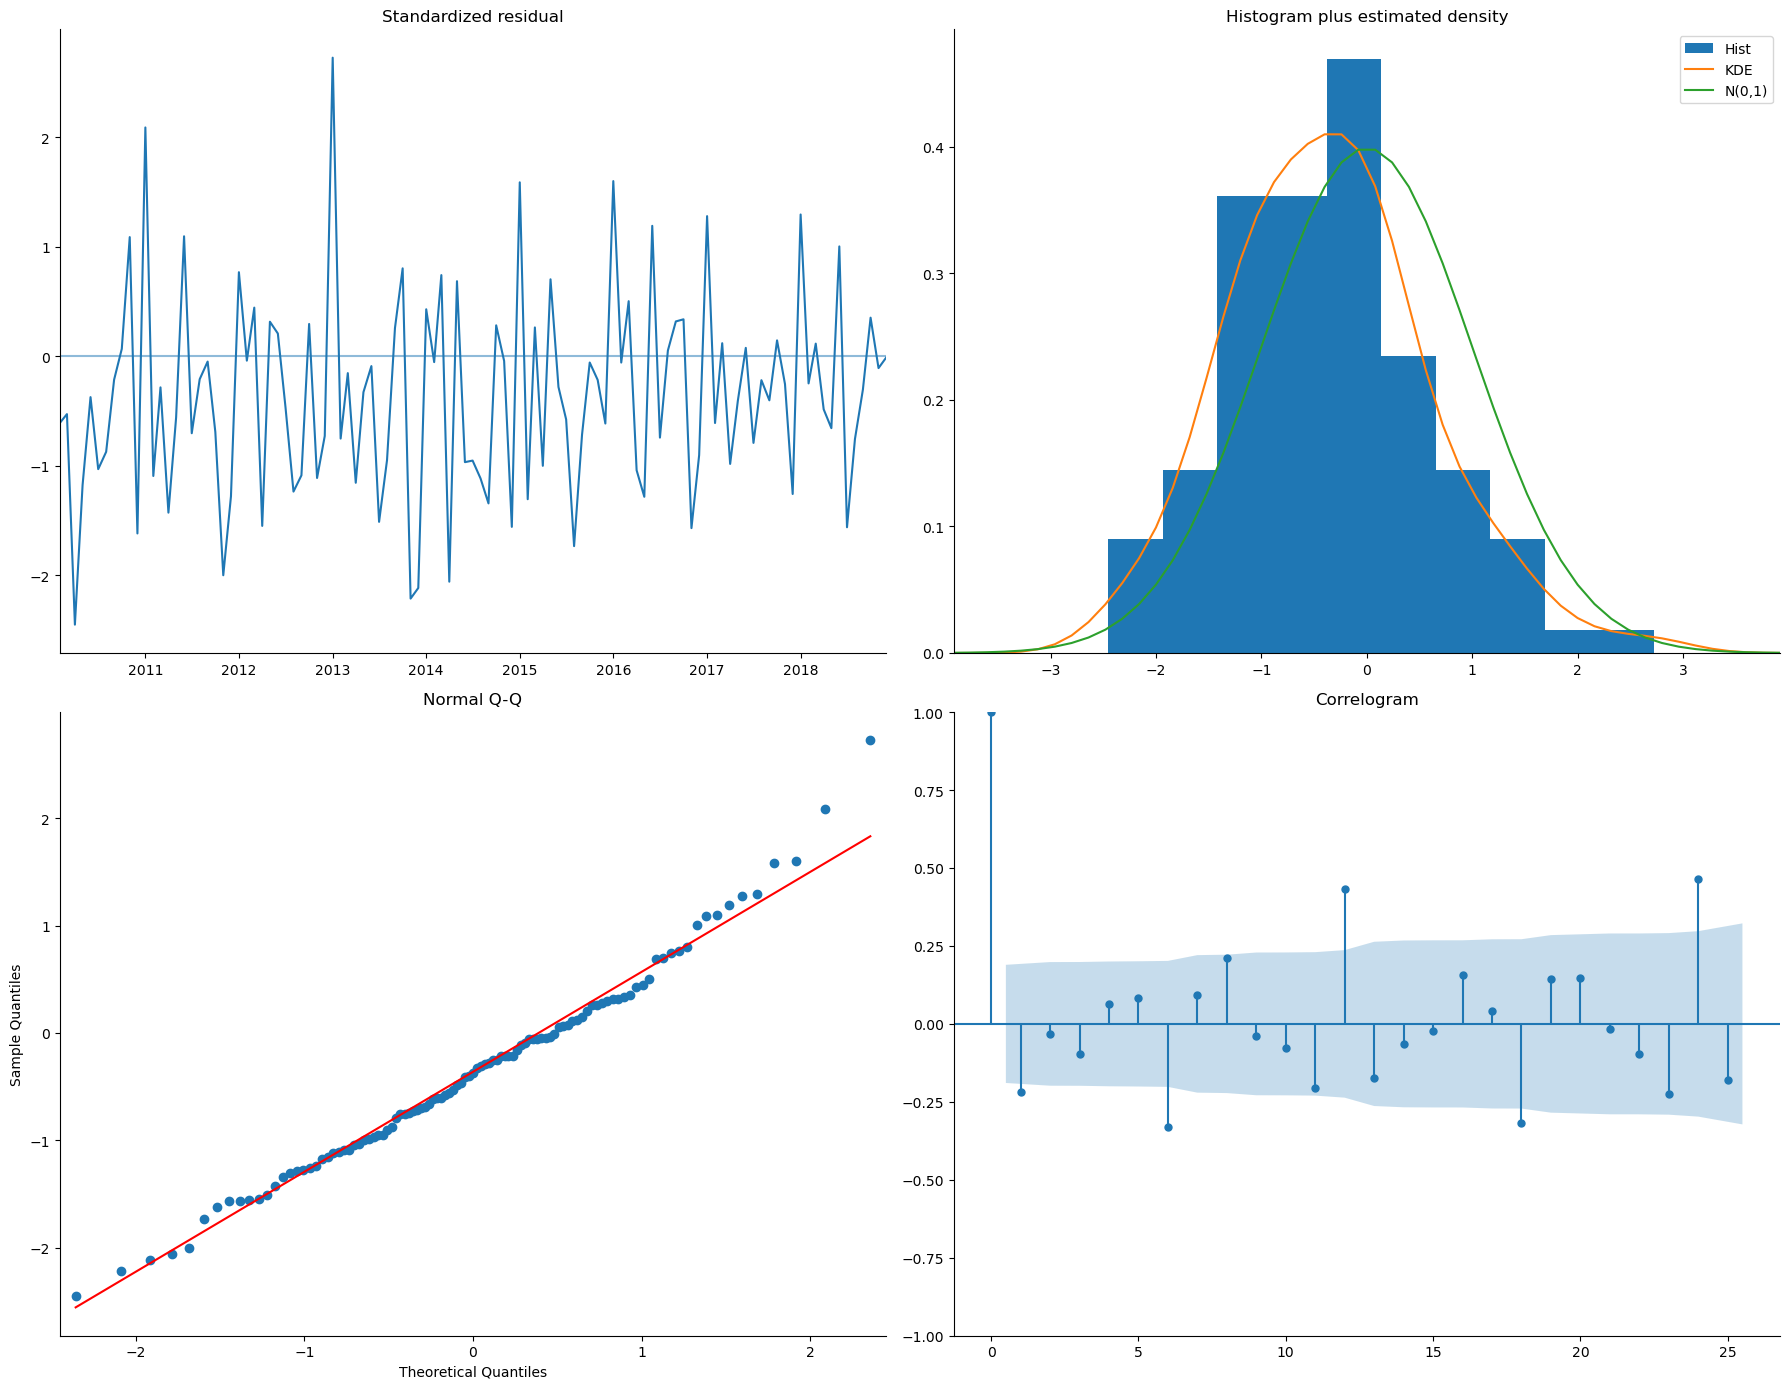

In [158]:
auto_arima.plot_diagnostics(figsize=(18, 14), lags=25)

sns.despine()
plt.tight_layout()

### 4. Find the best hyperparameters of a SARIMA model using the auto-ARIMA procedure.

In [159]:
auto_sarima = pm.auto_arima(df_train,
                            test='adf',
                            seasonal=True,
                            m=12,
                            with_intercept=False,
                            stepwise=True,
                            suppress_warnings=True,
                            trace=True)
auto_sarima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12]             : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=77.864, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-19.349, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12]             : AIC=39.115, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=77.461, Time=0.01 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=39.307, Time=0.03 sec
 ARIMA(1,1,0)(2,0,1)[12]             : AIC=inf, Time=0.44 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-19.382, Time=0.02 sec
 ARIMA(0,1,0)(2,0,0)[12]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(1,0,1)[12]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,1)[12]             : AIC=37.495, Time=0.02 sec
 ARIMA(0,1,0)(2,0,1)[12]             : AIC=inf, Time=0.30 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=-22.056, Time=0.04 sec


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  108
Model:             SARIMAX(0, 1, 5)x(2, 0, [1], 12)   Log Likelihood                  41.067
Date:                              Sat, 15 Jul 2023   AIC                            -64.135
Time:                                      14:15:08   BIC                            -40.079
Sample:                                  01-01-2010   HQIC                           -54.383
                                       - 12-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2797      0.115     -2.431      0.015      -0.505      -0.054
ma.L2         -0.1221      0.111     -1.100      0.271      -0.340       0.095
ma.L3         -0.2044      0.129     -1.590      0.112      -0.456       0.048
ma.L4          0.0728      0.125      0.583      0.560      -0.172       0.318
ma.L5          0.2494      0.102      2.457      0.014       0.050       0.448
ar.S.L12       0.8683      0.159      5.447      0.000       0.556       1.181
ar.S.L24       0.1297      0.152      0.852      0.394      -0.169       0.428
ma.S.L12      -0.8795      0.364     -2.420      0.016      -1.592      -0.167
sigma2         0.0199      0.006      3.395      0.001       0.008       0.031
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 1.92
Prob(Q):                              0.68   Prob(JB):                         0.38
Heteroskedasticity (H):               0.61   Skew:                            -0.29
Prob(H) (two-sided):                  0.14   Kurtosis:                         3.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Please refer to the following SO question to see why the procedure returns AIC=inf for some model specifications:

- https://stats.stackexchange.com/questions/160612/auto-arima-doesnt-calculate-aic-values-for-the-majority-of-models

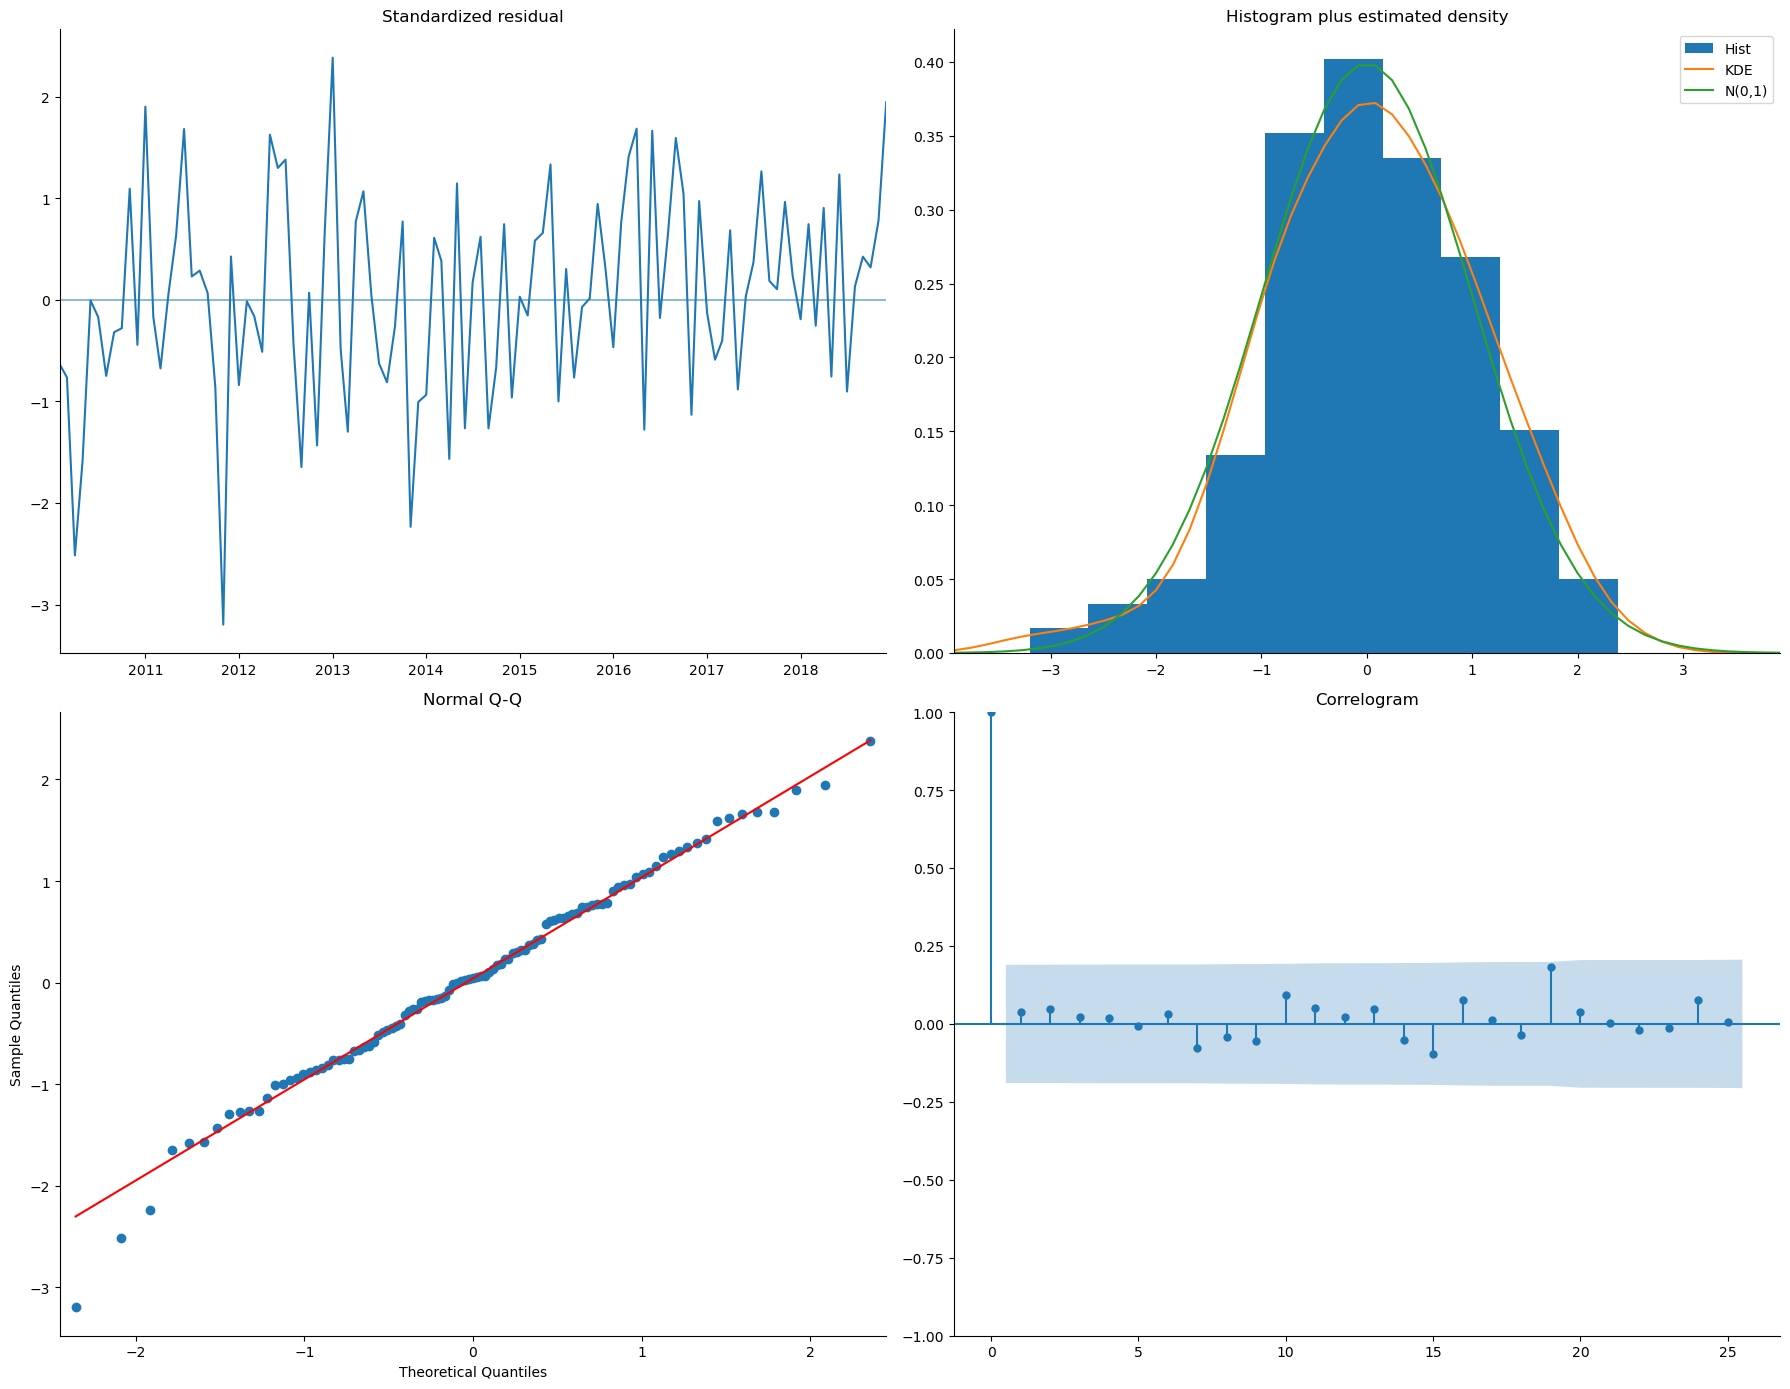

In [160]:
auto_sarima.plot_diagnostics(figsize=(18, 14), lags=25)

sns.despine()
plt.tight_layout()

### 5. Calculate the forecast from the two models and plot them.

/var/folders/dt/q9f0jq252ld5kmwg8rqf4pgw0000gn/T/ipykernel_49274/2235953460.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['auto_arima'] = auto_arima.predict(TEST_LENGTH)
/var/folders/dt/q9f0jq252ld5kmwg8rqf4pgw0000gn/T/ipykernel_49274/2235953460.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['auto_sarima'] = auto_sarima.predict(TEST_LENGTH)


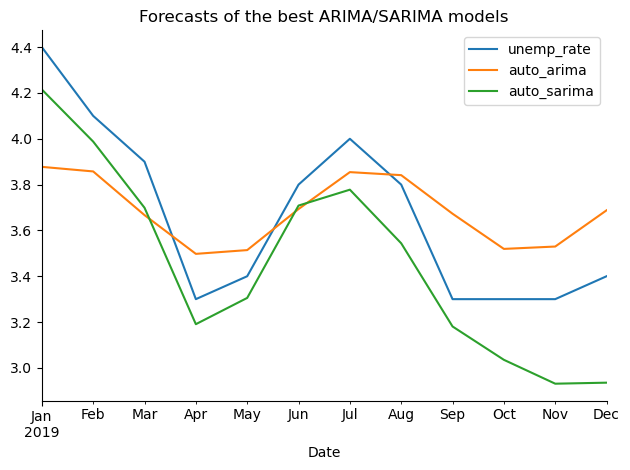

In [161]:
df_test['auto_arima'] = auto_arima.predict(TEST_LENGTH)
df_test['auto_sarima'] = auto_sarima.predict(TEST_LENGTH)
df_test.plot(title="Forecasts of the best ARIMA/SARIMA models")

sns.despine()
plt.tight_layout()

In [162]:
mape_auto_arima = mean_absolute_percentage_error(
    df_test['unemp_rate'],
    df_test['auto_arima']
)

mape_auto_sarima = mean_absolute_percentage_error(
    df_test['unemp_rate'],
    df_test['auto_sarima']
)

print(f"MAPE of auto-ARIMA: {100 * mape_auto_arima:.2f}%")
print(f'MAPE of auto-SARIMA: {100 * mape_auto_sarima:.2f}%')

MAPE of auto-ARIMA: 6.17%
MAPE of auto-SARIMA: 5.78%


## There's more

### 1. Import the libraries.

In [163]:
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import FourierFeaturizer
from pmdarima.preprocessing import LogEndogTransformer
from pmdarima import arima

### 2. Create new features (month dummies) and split them into the train/test sets.

In [164]:
month_dummies = pd.get_dummies(
    df.index.month, 
    prefix="month_", 
    drop_first=True
)
month_dummies.index = df.index
df = df.join(month_dummies)

df_train = df.iloc[:-TEST_LENGTH]
df_test = df.iloc[-TEST_LENGTH:]

### 3. Find the best hyperparameters of the ARIMAX model.

In [167]:
auto_arimax = pm.auto_arima(
    df_train[["unemp_rate"]],
    exogenous=df_train.drop(columns=["unemp_rate"]),
    test="adf",
    seasonal=False,
    with_intercept=False,
    stepwise=True,
    suppress_warnings=True,
    trace=True
)
                            
auto_arimax.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=7.411, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=77.864, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=77.461, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=75.688, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=68.551, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=54.321, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=7.458, Time=0.12 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=78.507, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=60.069, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=41.703, Time=0.03 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=10.333, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 0.912 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  108
Model:               SARIMAX(2, 1, 2)   Log Likelihood                   1.294
Date:                Sat, 15 Jul 2023   AIC                              7.411
Time:                        14:15:21   BIC                             20.775
Sample:                    01-01-2010   HQIC                            12.829
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9882      0.028     34.788      0.000       0.933       1.044
ar.L2         -0.9630      0.023    -41.667      0.000      -1.008      -0.918
ma.L1         -1.1926      0.057    -21.093      0.000      -1.303      -1.082
ma.L2          0.9241      0.063     14.580      0.000       0.800       1.048
sigma2         0.0550      0.009      6.066      0.000       0.037       0.073
===================================================================================
Ljung-Box (L1) (Q):                   5.22   Jarque-Bera (JB):                 4.47
Prob(Q):                              0.02   Prob(JB):                         0.11
Heteroskedasticity (H):               0.52   Skew:                             0.44
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

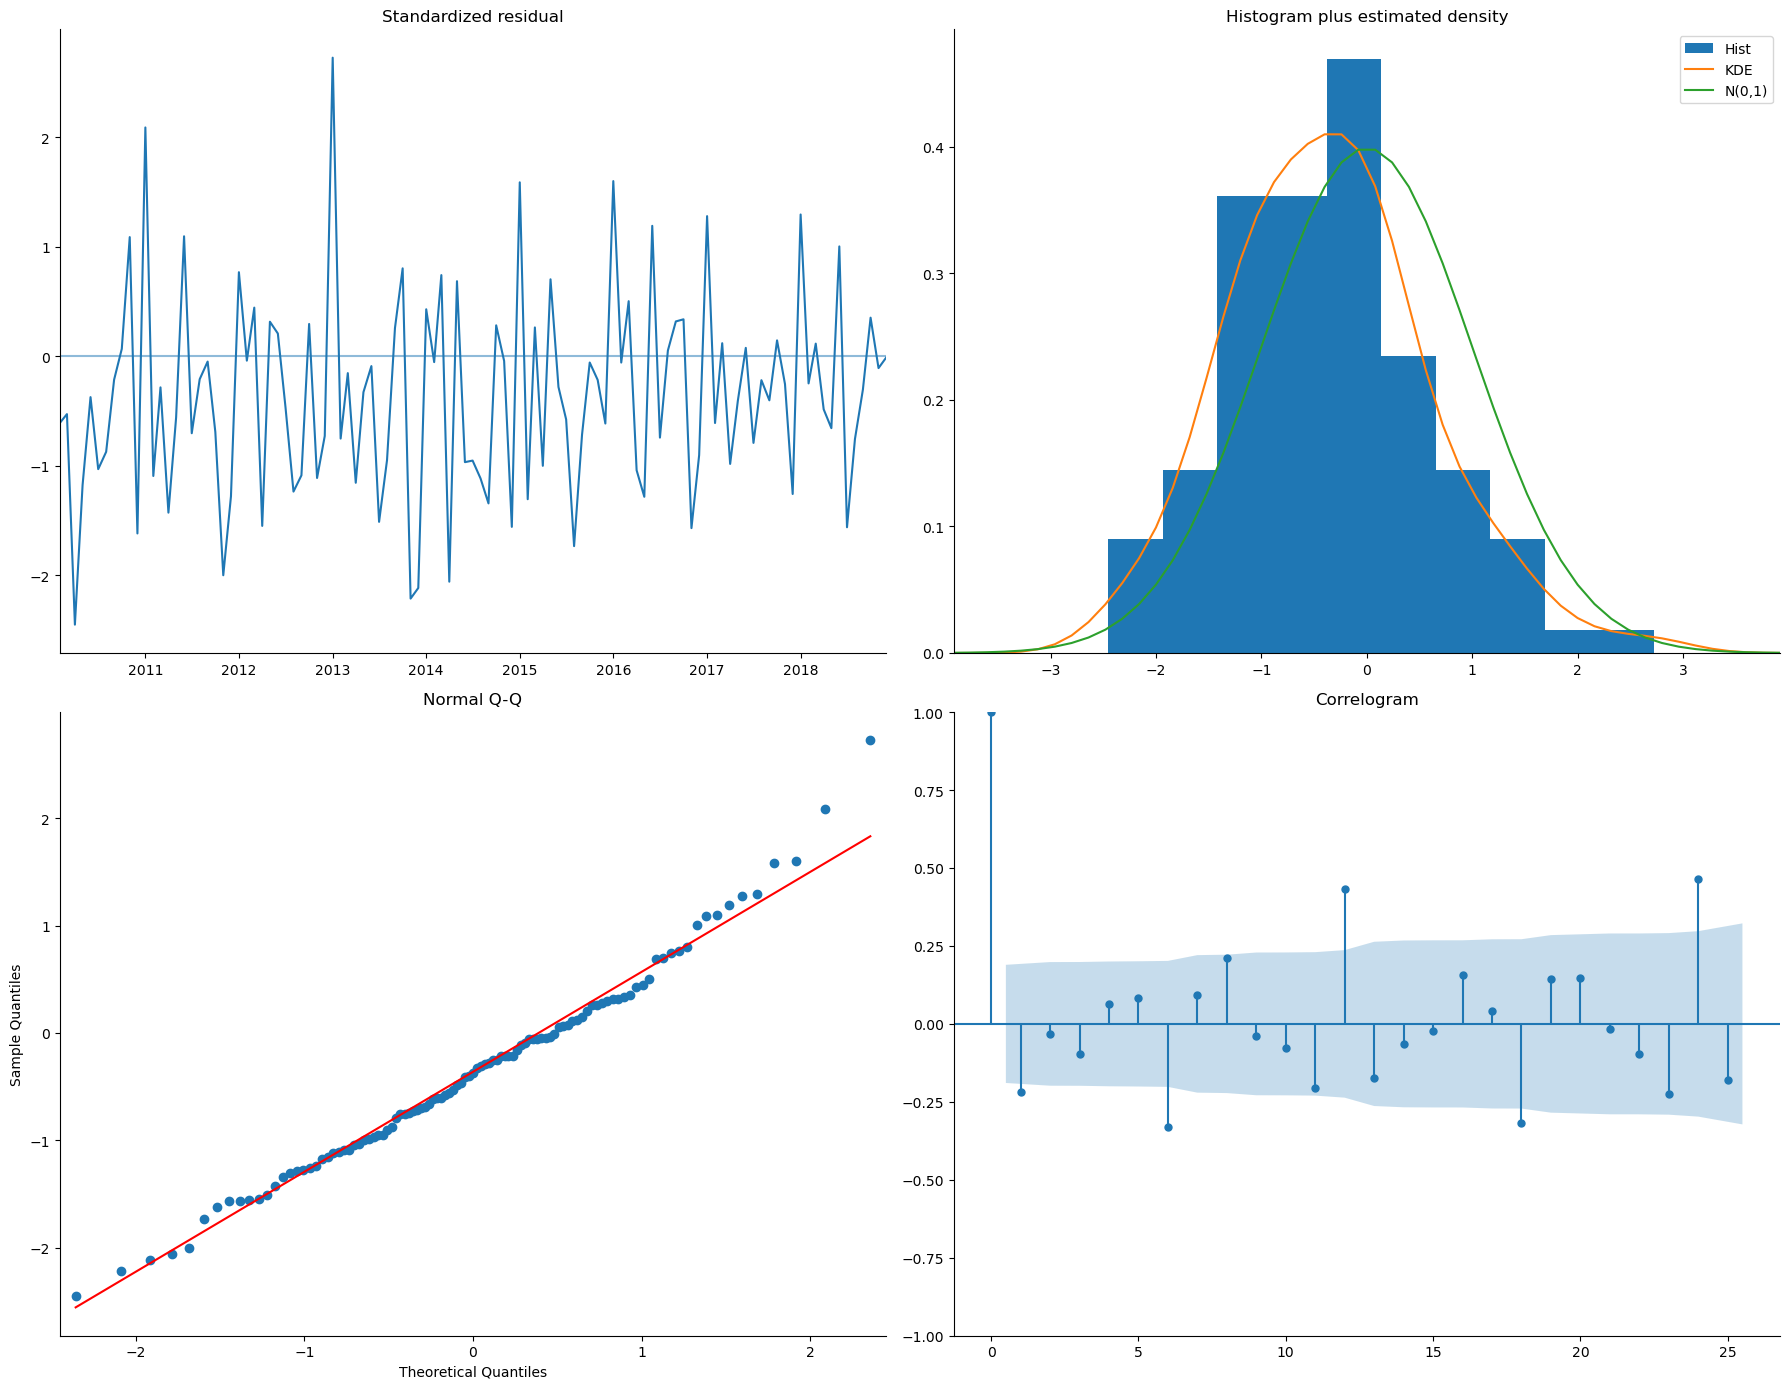

In [168]:
auto_arimax.plot_diagnostics(figsize=(18, 14), lags=25)

sns.despine()
plt.tight_layout()

### 4. Find the best hyperparameters of the ARIMAX pipeline.

In [170]:
auto_arima_pipe = Pipeline([
    ("log_transform", LogEndogTransformer()),
    ("fourier", FourierFeaturizer(m=12)),
    ("arima", arima.AutoARIMA(stepwise=True, trace=1,
                              error_action="warn",
                              test='adf', seasonal=False,
                              with_intercept=False,
                              suppress_warnings=True))
])

auto_arima_pipe.fit(df_train[["unemp_rate"]])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-443.949, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-451.806, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-449.936, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-449.932, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-447.934, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-462.898, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-464.399, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-465.503, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-475.671, Time=0.13 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-483.865, Time=0.25 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-482.069, Time=0.37 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-481.359, Time=0.44 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-478.937, Time=0.32 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-480.454, Time=0.37 sec
 ARIMA(4,1,0)(0,0,0)[0]          

Pipeline(steps=[('log_transform', LogEndogTransformer()),
                ('fourier', FourierFeaturizer(m=12)),
                ('arima',
                 AutoARIMA(error_action='warn', seasonal=False, test='adf',
                           trace=1, with_intercept=False))])

### 5. Calculate the forecasts and plot them

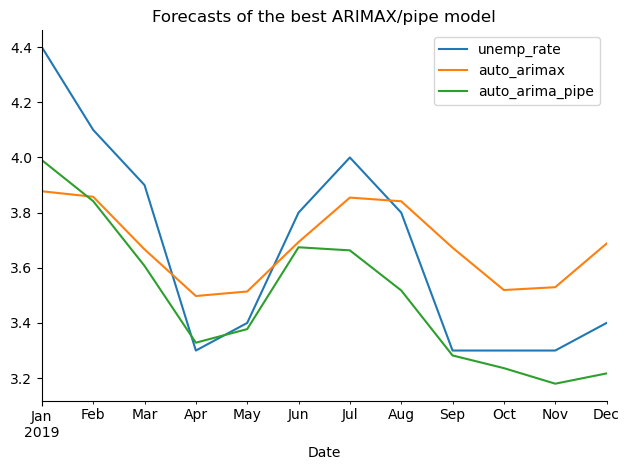

In [172]:
# specify return_conf_int when calling `predict` to get the confidence intervals

result_df = df_test[['unemp_rate']].copy()
result_df['auto_arimax'] = auto_arimax.predict(
    TEST_LENGTH,
    X=df_test.drop(columns=["unemp_rate"])
)
result_df['auto_arima_pipe'] = auto_arima_pipe.predict(TEST_LENGTH)
result_df.plot(title="Forecasts of the best ARIMAX/pipe model")

sns.despine()
plt.tight_layout()

### 7. Calculate the MAPEs

In [173]:
mape_auto_arimax = mean_absolute_percentage_error(
    result_df['unemp_rate'],
    result_df['auto_arimax']
)

mape_auto_pipe = mean_absolute_percentage_error(
    result_df['unemp_rate'],
    result_df['auto_arima_pipe']
)

print(f"MAPE of auto-ARIMAX: {100 * mape_auto_arimax:.2f}%")
print(f'MAPE of auto-ARIMA/pipe: {100 * mape_auto_pipe:.2f}%')

MAPE of auto-ARIMAX: 6.17%
MAPE of auto-ARIMA/pipe: 4.61%
